# 01. General

## 02. Latent Diffusion Architecture + Other Definitions

#### Content

### Stable Diffusion Architecture
0. [Latent Diffusion Process (Forward/Reverse)](#latentdiffusion)
1. [Variational Auto Encoder - VAE](#vae)
2. [Tokenizer and Text Encoder](#textencoder)
3. [Scheduler](#sched)
4. [UNet](#unet)
5. [Evaluating Diffusion Models](#evaluation)

### Advanced Image Control + Fine Tuning
6. [ControlNet](#controlnet)
7. [Low-Rank-Adaption LoRa](#lora)
8. [Dreambooth](#dreambooth)
9. [Textual Inversion](#textinversion)

<a id="latentdiffusion"></a>

## 0. Latent Diffusion Process (Forward/Reverse)

**[Ho, J., Jain, A., Abbeel, P. (2020): Denoising Diffusion Probabilistic Models. arXiv:2006.11239v2](https://arxiv.org/abs/2006.11239).**

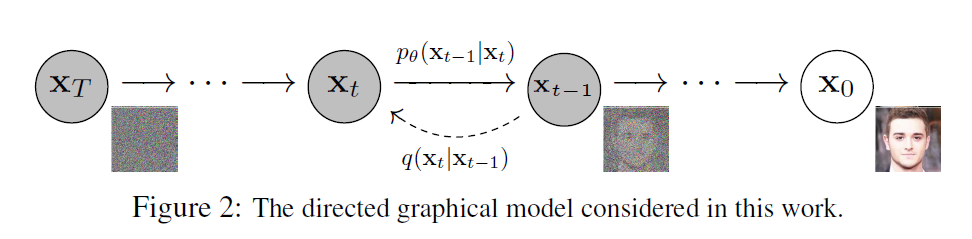

**<u>Forward Process</u>**

Process from a noisy image $x_{t-1}$ to a more noisy image $x_t$

$$
q(x_t|x_{t-q})= N(x_t, \sqrt{1-\beta_t}x_{t-1},\beta_t I)
  $$
where

$N$ = normal distribution, 
$x_t$ = output, 
$\sqrt{1-\beta_t}$ = mean, 
$\beta_t$ =  variance $\rightarrow$ Schedule (between 0 and 1)


mit der Notation 
$\alpha_t \coloneqq 1 - \beta_t$ 
und 
$\bar{\alpha}_t \coloneqq \prod_{s=1}^{t} \alpha_s $
wird daraus

$$ q(x_{t} | x_{0}) = \mathcal{N}(x_{t}; \sqrt{\alpha_{t}}x_{0}, (1 - \bar{\alpha}_{t})I) $$

**<u>Reverse Process</u>**

Process from a noisy image $x_t$ to a less noisy image $x_{t-1}$

$$ 
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_{\theta}(x_t,t),\Sigma_{\theta}(x_t)$$

Wobei:
$T = 1000$


$\beta_1 = 10^-4 $  to  $ \beta_T = 0.02$

### Latent Diffusion Process (Stable Diffusion Paper)
**[Rombach et. al. (2020): High-Resolution Image Synthesis with Latent Diffusion Models. arXiv:2112.10752v2](https://arxiv.org/abs/2112.10752)**

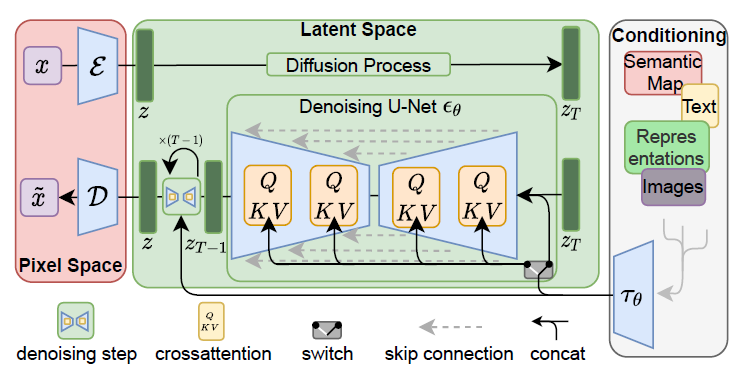

The encoder $\varepsilon$ encodes an image $x$ into a latent representation $z = \varepsilon_{(x)}$ and the decoder $D$ reconstructs the image from the latent, giving $\bar{x} = D_{(x)} = D(\varepsilon_{(x)})$. 

In the low-dimensional latent space high frequency, imperceptible details are abstracted away, leading to a much more efficient space compared to the high-dimensional pixel space. The neural backbone $\varepsilon_{\theta}(o, t)$ is realized as a time-conditional UNet. Since the forward process is fixed, $z_t$ can be efficiently obtained from $\varepsilon$ during training, and samples from $p_{(z)}$ can be decoded to image space with a single pass through $D$

<a id="vae"></a>

## 1. VAE (Autoencoder/-decoder)

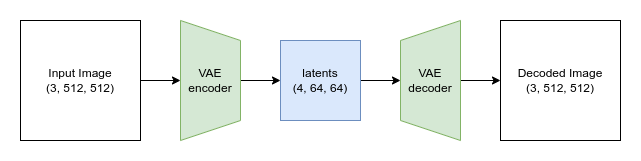

The VAE (variational autoencoder) is a type of model that can **encode its input into a compressed representation** and then **decode this 'latent' representation back into something close to the original input**. When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the **'latent space'** of the VAE, and then decode them at the end to view the resulting image.

<a id="textencoder"></a>

## 2. Tokenizer and Text Encoder  

[<u>Huggingface Diffusion Models Class</u>](https://github.com/huggingface/diffusion-models-class)

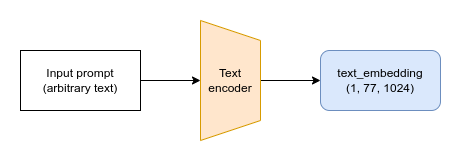

The goal of the text encoder is to turn an input string (the prompt) into a **numerical representation** that can be **fed to the UNet** as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about 50k tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

<a id="sched"></a>
## 3. Scheduler


The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a `PNDMScheduler`, but you can use others (such as `LMSDiscreteScheduler`) as long as they are initialized with the same configuration.
We can plot the noise schedule to see the noise level (based on $\overline{\alpha}$) over time

---


* defines the whole **denoising process** (How many denoising steps? Stochastic or deterministic? What algorithm is used to find the denoised sample?)
* Algorithms that are used alongside the UNet Component of the SD Pipeline
* Key role in the denoising process, run multiple times iterativly (steps) to create a clean image from completely random noise
    * Scheduler **control the noise levels during the diffusion process**, affecting the overall image quality
    * Sampler influence the variation and diversty of the generated outputs by introducing random perturbations to the images
    * they both require a **balance/trade-off** between **denoising speed** and **denoising quality**
      
* several different schedulers are available (over 10)
* during **training (forward process)** , a scheduler adds noise (there are different algorithms for how to add noise) to a sample to train a diffusion model
    *  it's not the same amount of noises added at each timestep (-> this is regulated by the scheduler, which **scales** the **mean** and the **variance**)
        *  a ***linear schedule*** wouldn't be optimal as the last couple timesteps already seem like complete noise and the information would be destroyed to fast
        *  the ***cosine schedule*** destroys the image information more slowly and 'saves' more information at the end
* during **inference (reverse process)**, a scheduler defines how to update a sample based on a pretrained models output


* the lower $a_t$ the more noise is added
* in the DDPM Paper the authors used a linear scheduler between $10^{-4}$ and $0.02$. At time $t=0$, the value of $\beta_t$ will be $10^{-4}$ at time $T$ it will be $0.02$ (Forward Process)
* in the Reverse Process the authors consturct the *loss function* so that the model is more biased toward learning higher values of $_t$ (see image below). which require it to denoise much more noise than lower values of $_t$. The idea is that higher values of $_t$ construct high-level features of the object and lower leves of $_t$ construct more fine_grained features in the image. It's more important to get the main shape of the object right than to make the object have some sort of texture.

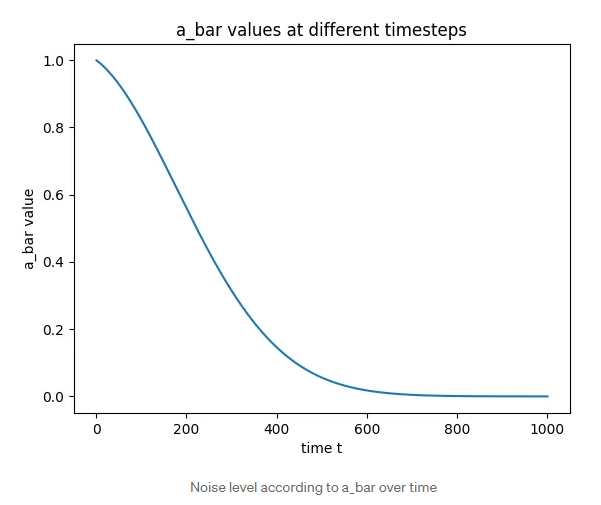


For Tests check out the [<u>Scheduler Notebook</u>](../2.0_basic_image_generation_and_functions/03_different_scheduler.ipynb)

---

https://huggingface.co/docs/diffusers/using-diffusers/schedulers

https://www.youtube.com/watch?v=HoKDTa5jHvg&list=LL&index=5

https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869

[https://blog.segmind.com/what-are-schedulers-in-stable-diffusion/#:~:text=Schedulers%20are%20algorithms%20that%20are,a%20completely%20random%20noisy%20image]



<a id="unet"></a>

## 4. UNet

The U-Net architecture, initially designed for medical image segmentation, is a type of convolutional neural network (CNN) with a distinctive U-shaped architecture. Its versatility has allowed it to be adapted for various applications beyond its original purpose, including image segmentation, image upscaling, and as a core component within diffusion models for image generation from gaussian noise to newly generated images.

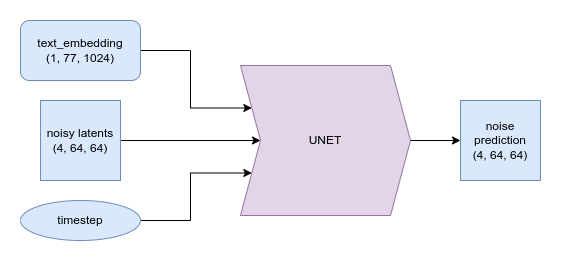

---
* **U-Shape**: The U-Net consists of a contracting path to capture context and a symmetric expanding path that enables precise localization, forming its notable U-shaped structure.
* **Image Input and Output**: At its core, the architecture takes an image input and is capable of producing a new one. In the context of diffusion models, this process involves transforming a noisy array of numbers into a coherent image output.
* **Core of Image Generation**: U-Net serves as the heart of the image generation model in diffusion processes. It processes encoded text (prompt) and a noisy numerical array as inputs.
* **Iterations**: Through many iterations, U-Net refines this noisy input, gradually producing an array containing imageable information, essentially "denoising" the input.
* **Decoder**: The output from U-Net is then used by a decoder to generate the final picture, translating the array into a visible image.

---

**Input:** latent representation of a (noisy) image at time $_t$ + the timestep $_t$ itself

**Output:** Noise in the image (as a representation to know where it's at -> new timestep)

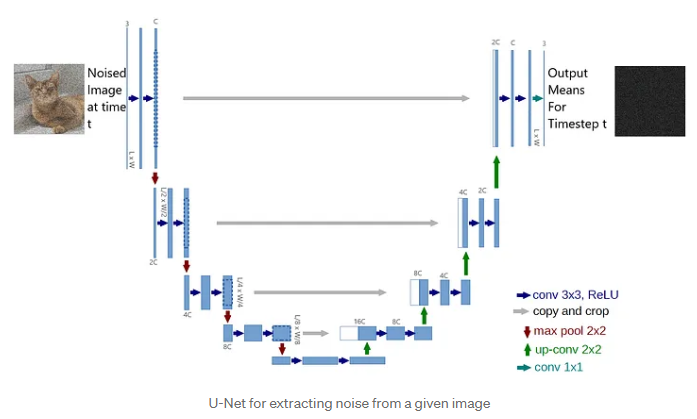



**Process:** 
* the input image will be compressed via Resnet-Blocks and Downsample-Blocks until the 'Bottle Neck', then it will be projected back to it's original size via Upsample-Blocks
* Attention-Blocks employ skip connections between the layers of the spacial of resolution
* the sinusoidal embedding is telling the model the exact timestep at each resudial block (-> this is important because different amount of noise apply at different timesteps

---

https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869


<a id="evaluation"></a>
## 5. Evaluating Diffusion Models

https://huggingface.co/docs/diffusers/conceptual/evaluation

Two different approaches: 

1. [**Qualitative Evaluation**](#qualitativ)   
2. [**Quantitative Evaluation**](#quantitativ)

These methods can also be used to **evaluate different noise schedulers** keeping the underlying model fixed.

<a id="qualitativ"></a>

### Qualitative Evaluation

* based on Human Evaluation
* **prompt datasets** für qualitative benchmarking (e.g. [**DrawBench**](https://imagen.research.google/) from Google [(this is the dataset)](https://docs.google.com/spreadsheets/d/1y7nAbmR4FREi6npB1u-Bo3GFdwdOPYJc617rBOxIRHY/edit#gid=0) or [**PartiPrompts**](https://sites.research.google/parti/) from Parti measuring model capabilities across various categories (like Animals, People, Food, ...) and different challenge aspects (like Perspective, Writing, Positioning, Complexity) --> see image below
  

<img src="https://sites.research.google/parti/assets/bcp.png" alt="PartiPrompts" width="800"/>

<a id="quantitativ"></a>

### Quantitative Evaluation

1. [CLIP Score](#clipscore)
2. [CLIP directional similarity](#clipsimilarity)
3. [FID](#fid)

<a id="clipscore"></a>

**1. CLIP Score**

[**Hessel, J., Hltzman, A., Forbes, M., Le Bras, R., Choi, Y. (2021): ClipScore: A Reference-free Evaluation Metric for Image Captioning. arXiv2104.08718**](https://arxiv.org/abs/2104.08718)

* measures the compatibility of image-camption pairs
* higher CLIP scores = higher compatibility
* high correlation with human judgement

<a id="clipsimilarity"></a>

**2. Clip directional similarity**

[**Gal, R., Patashink, R., Maron, H., Bermano, A., Chechik, G., Cohen-Or, D. (2021): StyleGAN-NADA: CLIP-Guided Domain Adaption of Image Generators. arXiv: 2108.009446**](https://arxiv.org/abs/2108.00946)

* measures the consistency of the change between two images (in CLIP space) with the change between the two image captions
* the higher the CLIP directional similarity, the better

<a id="fid"></a>

**3. FID (Fréchet Inception Distance)**

[**Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., Hochreiter, S. (2018): GANs Trained by a Two-Scale Update Rule Converge to a Local Nash Equilibrium. arXiv 1706.08500**](https://arxiv.org/abs/1706.08500)

* measures **how similar tow datasets of images are** (one dataset with **real images** and one dataset with **generated images**)
* correlates well with the human judgement of visual quality and is most often used to evaluate the quality of samples of GANs
* FID is calculated by computing the Fréchet distance between two Gaussians fitted to feature representations of the Inception network
* **the lower the FID the better** (the lower the more similar the generated images are to the real ones)
  
* the FID can be influenced by:
    * the number of images
    * randomness induced in the diffusion process
    * number of inference steps
    * scheduler being used 

<a id="advancedcontrol"></a>

# Advanced Control + Fine Tuning

<a id="controlnet"></a>

## 6. ControlNet

**[Zhang, L., Rao, A., Agrawala, M. (2023): Adding conditional Control to Text-to-Image Diffusion Models. arXiv:2302.05543v2](https://arxiv.org/abs/2302.05543)**

ControlNet is a type of model for controlling image diffusion models by **conditioning the model with an additional input image**. There are many types of conditioning inputs (canny edge, user sketching, human pose, depth, and more) you can use to control a diffusion model. This is hugely useful because it affords you greater control over image generation, making it easier to generate specific images without experimenting with different text prompts or denoising values as much.

A ControlNet model has two sets of weights (or blocks) connected by a zero-convolution layer:

* a locked copy keeps everything a large pretrained diffusion model has learn
* a trainable copy is trained on the additional conditioning input

Since the locked copy preserves the pretrained model, training and implementing a ControlNet on a new conditioning input is as fast as finetuning any other model because you aren’t training the model from scratch

For examples for each technique and how they can be combined check the [<u>ControlNET Notebook</u>](../4.0_advanced_image_generation/01_controlnet.ipynb)

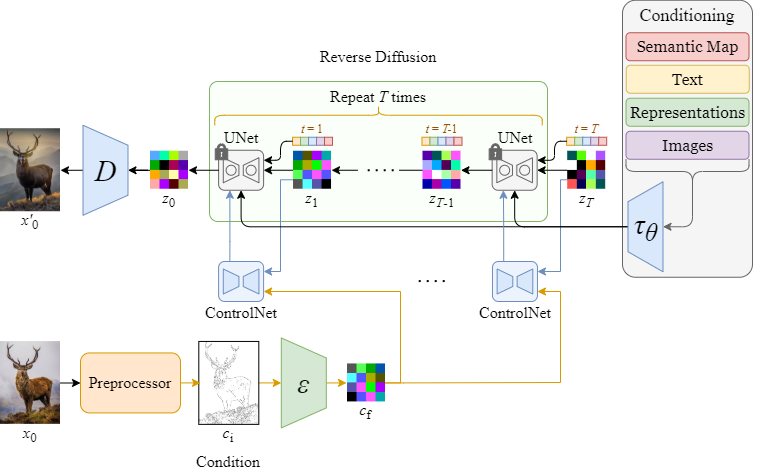

---

**The Paper proposed 8 different Options:**

1. Normal Map
    * the normal model was trained from an initial model and then a further extended model. The initial normal model was trained on 25,452 normal-image, caption pairs from DIODE. The image captions were generated by BLIP. The model was trained for 100 GPU-hours with Nvidia A100 80G using Stable Diffusion 1.5 as a base model.
2. Canny Edge (Edge Detector)
    * An image containing the detected edges (annotation or preprocessing) is then saved as a control map. It is fed into the ControlNet model as an extra conditioning to the text prompt.
3. Openpose (Human Pose Detector)
    * Openpose is a fast human keypoint detection model that can extract human poses like positions of hands, legs, and head
4. Depth Map
5. M-LSD Line
6. HED Edge Detection
7. Image Segmentation (ADE20K)
    * The semantic segmentation model was trained on 164K segmentation-image, caption pairs from ADE20K. The model was trained for 200 GPU-hours with Nvidia A100 80G using Stable Diffusion 1.5 as a base model.
8. Scribble (Hand-drawn sketch)
   
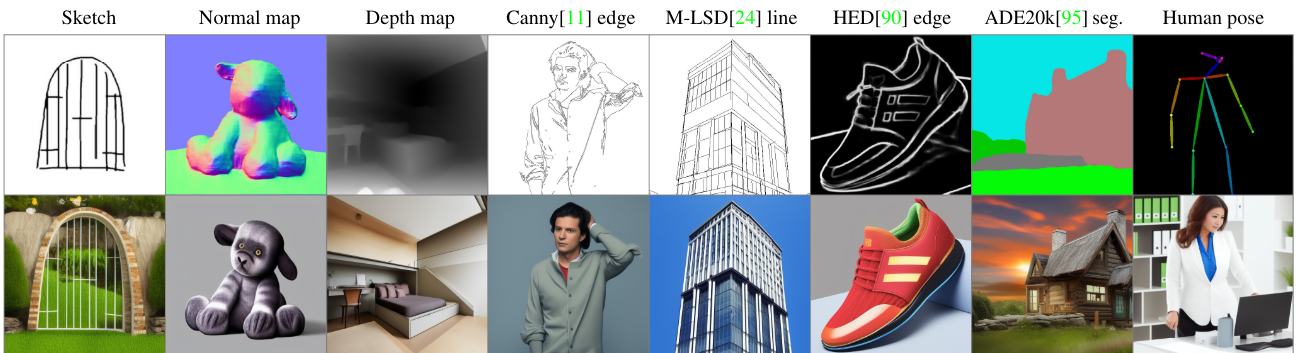

---

https://huggingface.co/blog/train-your-controlnet

https://huggingface.co/lllyasviel/sd-controlnet-seg

https://huggingface.co/blog/controlnet

https://github.com/lllyasviel/ControlNeth.

<a id="lora"></a>

## 7. Low-Rank-Adaption (LoRa)


**[Hu, E. J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L., Chen, W., (2021): LoRa: Low-Rank Adaption Of Large Language Models. arXiv: 2103.09685v2](https://arxiv.org/abs/2106.09685)**

* most popular form of **PEFT** (Parameter-Efficient-Fine-Tuning)
* fine-tuning of large models while consuming less memory
* popular training technique because it is fast and generates smaller file sizes (a couple hundred MBs)
* LoRa can train a model to learn new styles from just a few images
* it **works by inserting new weights into the diffusion model and then only the new weights are trained instead of the entire model**
* can be used with other other training methods (e.g. to **train a model with Dreambooth and LoRa**)
* LoRas need to be used with another model (like SDXL Base)

* LoRa makes fine-tuning more efficient by drastically reducing the number of trainable parameters, but
* the **original pre-trained-weights are kept frozen**, which means you can have multible lightweight and protable LoRa models for various downstream tasks build on top of them
* Performance of models fine-tuned using LoRa is **comparable to the performance of fully fine-tuned models**

For tests check out the [<u>LoRa Notebook</u>](../4.0_advanced_image_generation/02_lora.ipynb)

---

https://huggingface.co/docs/peft/conceptual_guides/lora

https://huggingface.co/docs/diffusers/training/lora

<a id="dreambooth"></a>

## 8. Dreambooth

**[Ruiz, N., Li, Y., Jampani, V, Pritch, Y., Rubinstein, M., Aberman, K. (2023): Dreambooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation. arXiv: 2208.12242v2.](https://arxiv.org/abs/2208.12242)**

DreamBooth is a training technique that updates the entire diffusion model by training on just a few images of a subject or style. It works by associating a special word in the prompt with the example images.

* Fine Tuning Method with very few Images
* approach for **"personalization"**, that learns just **one specific object** (like your dog or bagpack) that is fixed to a unique identifier
* trained on a unique identifier (e.g. [V]) and a subject class (e.g. ["A Dog"])
    * --> **"A [V] Dog"**
* could also be combined, e.g. **Dreambooth + LoRa** (see the [<u>Campusbier Fine-Tuning Notebook</u>](../4.0_advanced_image_generation/03_sdxl_dreambooth_lora_campusbier.ipynb))


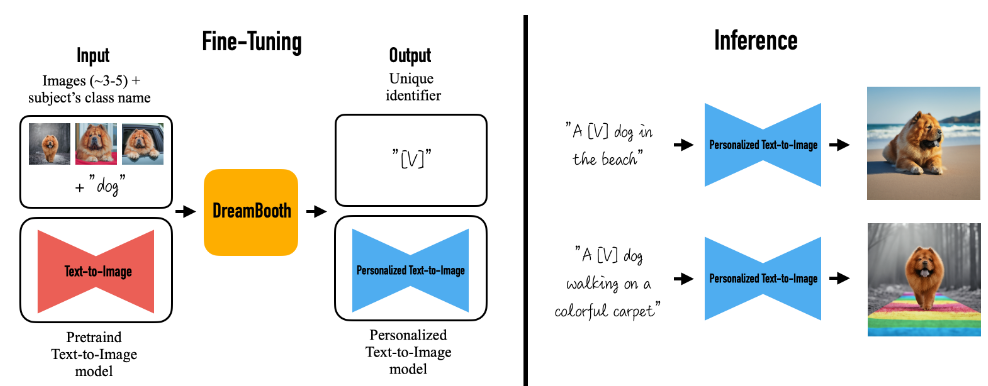

**Example Pictures**

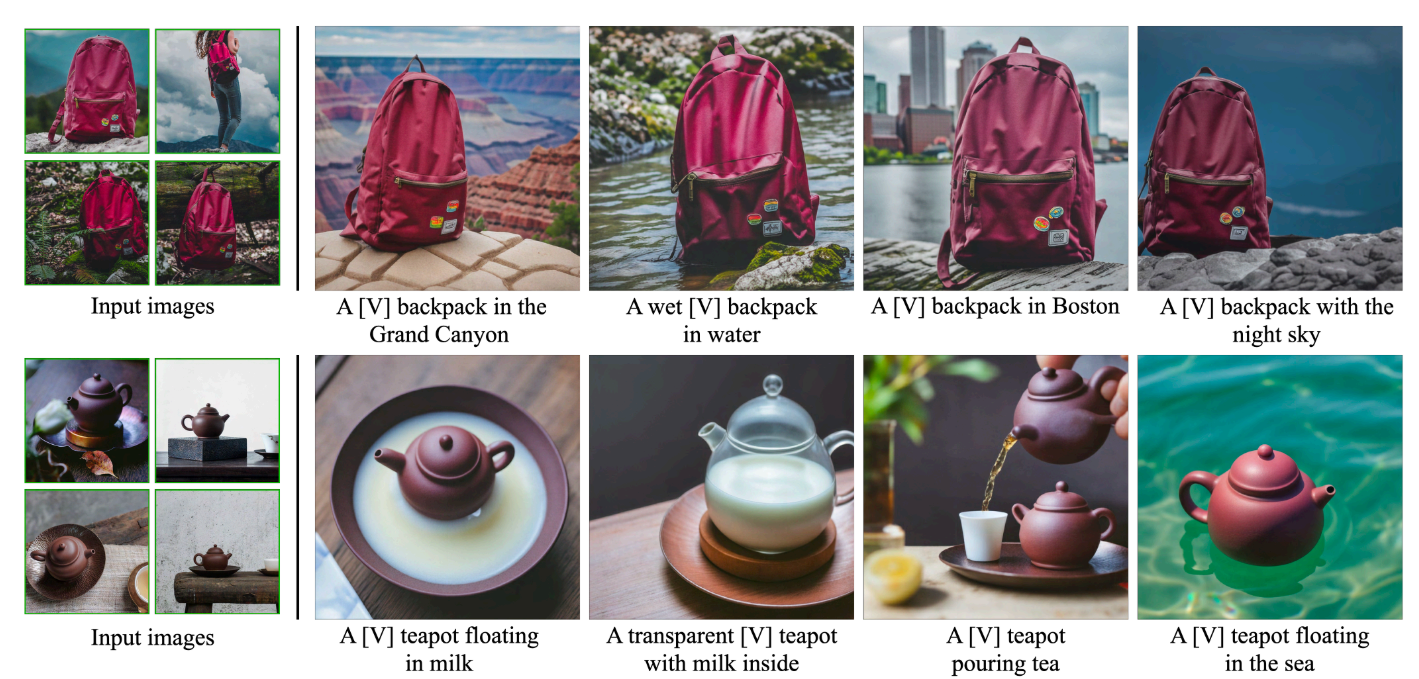

---

https://huggingface.co/docs/diffusers/main/en/training/dreambooth

<a id="textinversion"></a>

## 9. Textual Inversion

**[Gal, R., et al. (2022): An Image is Worth One Words: Personalizing Text-to-Image Generation using Textual Inversion. arXiv: 2208.01618v1](https://arxiv.org/abs/2208.01618)**

Textual Inversion is a training technique for personalizing image generation models with just a few example images of what you want it to learn. This technique works by learning and updating the text embeddings (the new embeddings are tied to a special word you must use in the prompt) to match the example images you provide.

* you can teach the model new words, like the name of your toy by updating the text embeddings
* works on a small set of images (3 - 5), which depicit the target concept across multiple settings such as backgrounds and poses
* works for text-guided synthesis and style transfer

This approach has **not been tested** during the project.

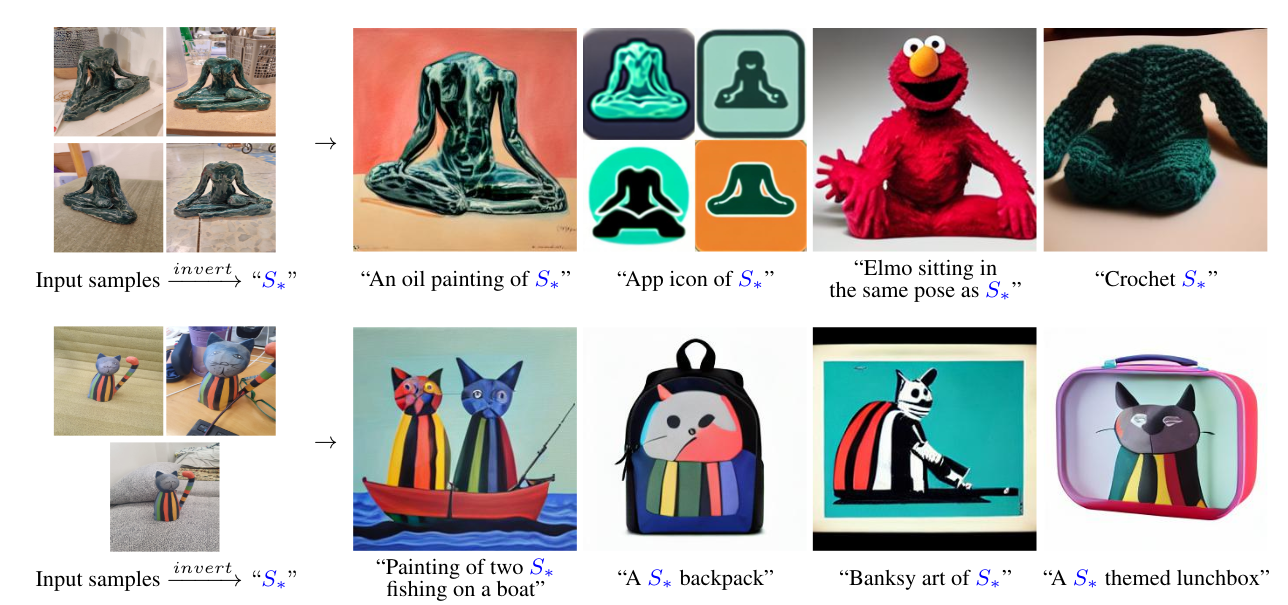

---
https://huggingface.co/docs/diffusers/main/en/training/text_inversion

https://textual-inversion.github.io/
